# Dados Fianceiros e Preprocessamento

Receitas:

* Obtendo dados do Yahoo Finance
* Obtendo dados do Quandl
* Obtendo dados do Intrinio
* Convertendo preços em retornos
* Alterando a frequância
* Visualizando dados de séries temporais
* Identificando _outliers_
* Investigando fatos estilizados de retornos de ativos

## Obtendo dados do Yahoo Finance

In [1]:
# Bibliotecas
import pandas as pd
import yfinance as yf

In [2]:
# Download dos dados
df_yahoo = yf.download(
    'AAPL',
    start='2000-01-01',
    end='2010-12-31',
    progress=False
)

In [3]:
df_yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.858138,535796800
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.785788,512377600
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.797286,778321600
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.728290,767972800
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.762789,460734400


## Obterndo dados do Quandl

In [4]:
# Libraries
import pandas as pd
import quandl

In [5]:
# Autentication
with open('quandl_api_key.txt') as f:
    QUANDL_KEY = f.readline()
quandl.ApiConfig.api_key = QUANDL_KEY

In [6]:
df_quandl = quandl.get(dataset='WIKI/AAPL',
                       start_date='2000-01-01',
                       end_date='2010-12-31')

In [7]:
df_quandl.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


## Obtendo dados do Intrinio

In [8]:
# Libraries
import pandas as pd
import intrinio_sdk

In [9]:
# Autentication
with open('intrinio_api_key.txt') as f:
    INTRINIO_KEY = f.readline()
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = INTRINIO_KEY
security_api = intrinio_sdk.SecurityApi()

In [10]:
# Request
r = security_api.get_security_stock_prices(
    identifier='AAPL',
    start_date='2000-01-01',
    end_date='2010-12-31',
    frequency='daily',
    page_size=10000
)

In [11]:
# Convert the results into a DataFrame
response_list = [x.to_dict() for x in r.stock_prices]
df_intrinio = pd.DataFrame(response_list).sort_values('date')
df_intrinio.set_index('date', inplace=True)

In [12]:
df_intrinio.head()

,intraperiod,frequency,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume,factor,split_ratio,dividend,change,percent_change,fifty_two_week_high,fifty_two_week_low
date,,,,,,,,,,,,,,,,,,,
2000-01-03,False,daily,104.87,112.50,101.69,111.94,4783900.0,0.803956,0.862450,0.779578,0.858157,5.357968e+08,1.0,1.0,0.0,0.07,0.0888,0.9,0.25
2000-01-04,False,daily,108.25,110.62,101.19,102.50,4574800.0,0.829868,0.848037,0.775745,0.785787,5.123776e+08,1.0,1.0,0.0,-0.07,-0.0843,0.9,0.25
2000-01-05,False,daily,103.75,110.56,103.00,104.00,6949300.0,0.795370,0.847577,0.789621,0.797287,7.783216e+08,1.0,1.0,0.0,0.01,0.0146,0.9,0.25
2000-01-06,False,daily,106.12,107.00,95.00,95.00,6856900.0,0.813539,0.820285,0.728291,0.728291,7.679728e+08,1.0,1.0,0.0,-0.07,-0.0865,0.9,0.25
2000-01-07,False,daily,96.50,101.00,95.50,99.50,4113700.0,0.739790,0.774288,0.732124,0.762789,4.607344e+08,1.0,1.0,0.0,0.03,0.0474,0.9,0.25


## Convertendo preços em retornos

Os preços de ativos geralmente são não estacionarios, o que significa que suas estatísticas, tais como média e variância (momentos matemáticos) mudam com o tempo. Por sua vez, os retornos são séries temporais estacionárias, o que é uma propriedade desejada em modelos estatísticos.

Existem dois tipos de retornos:

* Retorno Simples:
    $$R_t = \dfrac{P_t - P_{t-1}}{P_{t-1}} = \dfrac{P_t}{P_{t-1}} - 1$$
    
* Retorno Logarítnico:
    $$r_t = \log(P_t/P_{t-1}) = \log(P_t) - \log(P_{t-1})$$
    
em que $P_t$ é o preço do ativo no tempo $t$.

In [13]:
# Bibliotecas
import pandas as pd
import numpy as np
import yfinance as yf

In [14]:
# Download dos dados e mantendo apenas o pço ajustado
df = yf.download(
    'AAPL',
    start='1999-12-31',
    end='2010-12-31',
    progress=False
)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [15]:
# Cálculo do retorno simples e do retorno logarítmico
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [16]:
df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
1999-12-31,0.788183,NaN,NaN
2000-01-03,0.858137,0.088754,0.085033
2000-01-04,0.785788,-0.084310,-0.088078
2000-01-05,0.797286,0.014633,0.014527
2000-01-06,0.728291,-0.086538,-0.090514


### Como contabilizar a inflação em séries de retornos

Podemos avaliar o impacto da inflação sobre os retornos de ativos por meio da fórmula:

$$R_t^r = \dfrac{1 + R_t}{1 + \pi_t} - 1$$

em que $R_t$ e $\pi_t$ são respectivamente o retorno simples e a taxa de inflação no tempo $t$.

In [17]:
# Bibliotecas
import pandas as pd
import quandl

# Autenticação
with open('quandl_api_key.txt') as f:
    QUANDL_KEY = f.readline()
quandl.ApiConfig.api_key = QUANDL_KEY

In [18]:
# Criação do DataFrame com todas as datas possíveis e left join dos preços
df_all_dates = pd.DataFrame(index=pd.date_range(start='1999-12-31', end='2010-12-31'))
df = df_all_dates.join(df[['adj_close']], how='left').fillna(method='ffill').asfreq('M')

In [19]:
df.head()

,adj_close
1999-12-31,0.788183
2000-01-31,0.795370
2000-02-29,0.878741
2000-03-31,1.041169
2000-04-30,0.951090


In [20]:
# Download dos dados de inflação do Quandl
df_cpi = quandl.get(
    dataset='RATEINF/CPI_USA',
    start_date='1999-12-31',
    end_date='2010-12-31'
)

df_cpi.rename(columns={'Value':'cpi'}, inplace=True)

In [21]:
# Merge os dados de inflação aos dados de preços
df_merged = df.join(df_cpi, how='left')

In [22]:
# Cálculo do retorno simples e da taxa de inflação
df_merged['simple_rtn'] = df_merged.adj_close.pct_change()
df_merged['inflation_rate'] = df_merged.cpi.pct_change()
df_merged.head()

,adj_close,cpi,simple_rtn,inflation_rate
1999-12-31,0.788183,168.3,NaN,NaN
2000-01-31,0.795370,168.8,0.009118,0.002971
2000-02-29,0.878741,169.8,0.104820,0.005924
2000-03-31,1.041169,171.2,0.184842,0.008245
2000-04-30,0.951090,171.3,-0.086516,0.000584


In [23]:
# Retorno ajustado pela infçação
df_merged['real_rtn'] = (df_merged.simple_rtn + 1)/(df_merged.inflation_rate + 1) - 1
df_merged

,adj_close,cpi,simple_rtn,inflation_rate,real_rtn
1999-12-31,0.788183,168.300,NaN,NaN,NaN
2000-01-31,0.795370,168.800,0.009118,0.002971,0.006129
2000-02-29,0.878741,169.800,0.104820,0.005924,0.098314
2000-03-31,1.041169,171.200,0.184842,0.008245,0.175153
2000-04-30,0.951090,171.300,-0.086516,0.000584,-0.087050
...,...,...,...,...,...
2010-08-31,7.454631,218.312,-0.055005,0.001381,-0.056308
2010-09-30,8.701159,218.439,0.167215,0.000582,0.166537
2010-10-31,9.229516,218.711,0.060723,0.001245,0.059403
2010-11-30,9.541371,218.803,0.033789,0.000421,0.033354


## Alterando a freqência

Regra:

* Multiplicar/dividir os retornos logarítimicos pelo número de períodos de tempo
* Multiplicar/dividir a volatilidade pela raiz quadrada do número de períodos

No que segue, calculamos a volatilidade mensal para a Apple usando os retornos diários. A fórmula para a volatilidade é:

$$RV = \sqrt{\sum_{i = 1}^T  r_t^2}$$

Os passos são os seguintes:

* Baixar os dados e calcular os retornos logarítmicos
* Calcular a volatilidade percebida 
* Anualizar os valores multiplicando-os por $\sqrt{12}$

In [24]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Options
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

In [26]:
# Download dos dados e mantendo apenas o pço ajustado
df = yf.download(
    'AAPL',
    start='1999-12-31',
    end='2010-12-31',
    progress=False
)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [27]:
# Cálculo do retorno logarítmico
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [28]:
# Função para o cálculo da volatilidade
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

In [29]:
# Cálculo da volatilidade mensal
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn':'rv'}, inplace=True)
df_rv.head()

,adj_close,rv
Date,,
1999-12-31,0.788183,0.000000
2000-01-31,3.551689,0.251084
2000-02-29,3.831639,0.147841
2000-03-31,4.734313,0.243592
2000-04-30,4.119167,0.212513


In [30]:
# Anualizar os valores
df_rv.rv = df_rv.rv * np.sqrt(12)

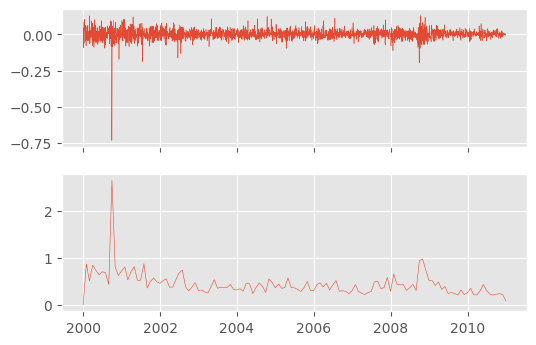

In [31]:
# Plotagem dos resultados
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(df[['log_rtn']], linewidth=0.4)
ax[1].plot(df_rv[['rv']], linewidth=0.4)
plt.show()

## Visualizando dados de séries temporais

In [32]:
# Bibliotecas importadas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [33]:
# Options
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

In [34]:
# Download dos dados e mantendo apenas o pço ajustado
df = yf.download(
    'MSFT',
    start='1987-12-31',
    end='2020-12-31',
    progress=False
)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [35]:
# Cálculo do retorno simples e do retorno logarítmico
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [36]:
df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
1987-12-31,0.238277,NaN,NaN
1988-01-04,0.245963,0.032259,0.031749
1988-01-05,0.250355,0.017856,0.017699
1988-01-06,0.256944,0.026317,0.025976
1988-01-07,0.265728,0.034189,0.033617


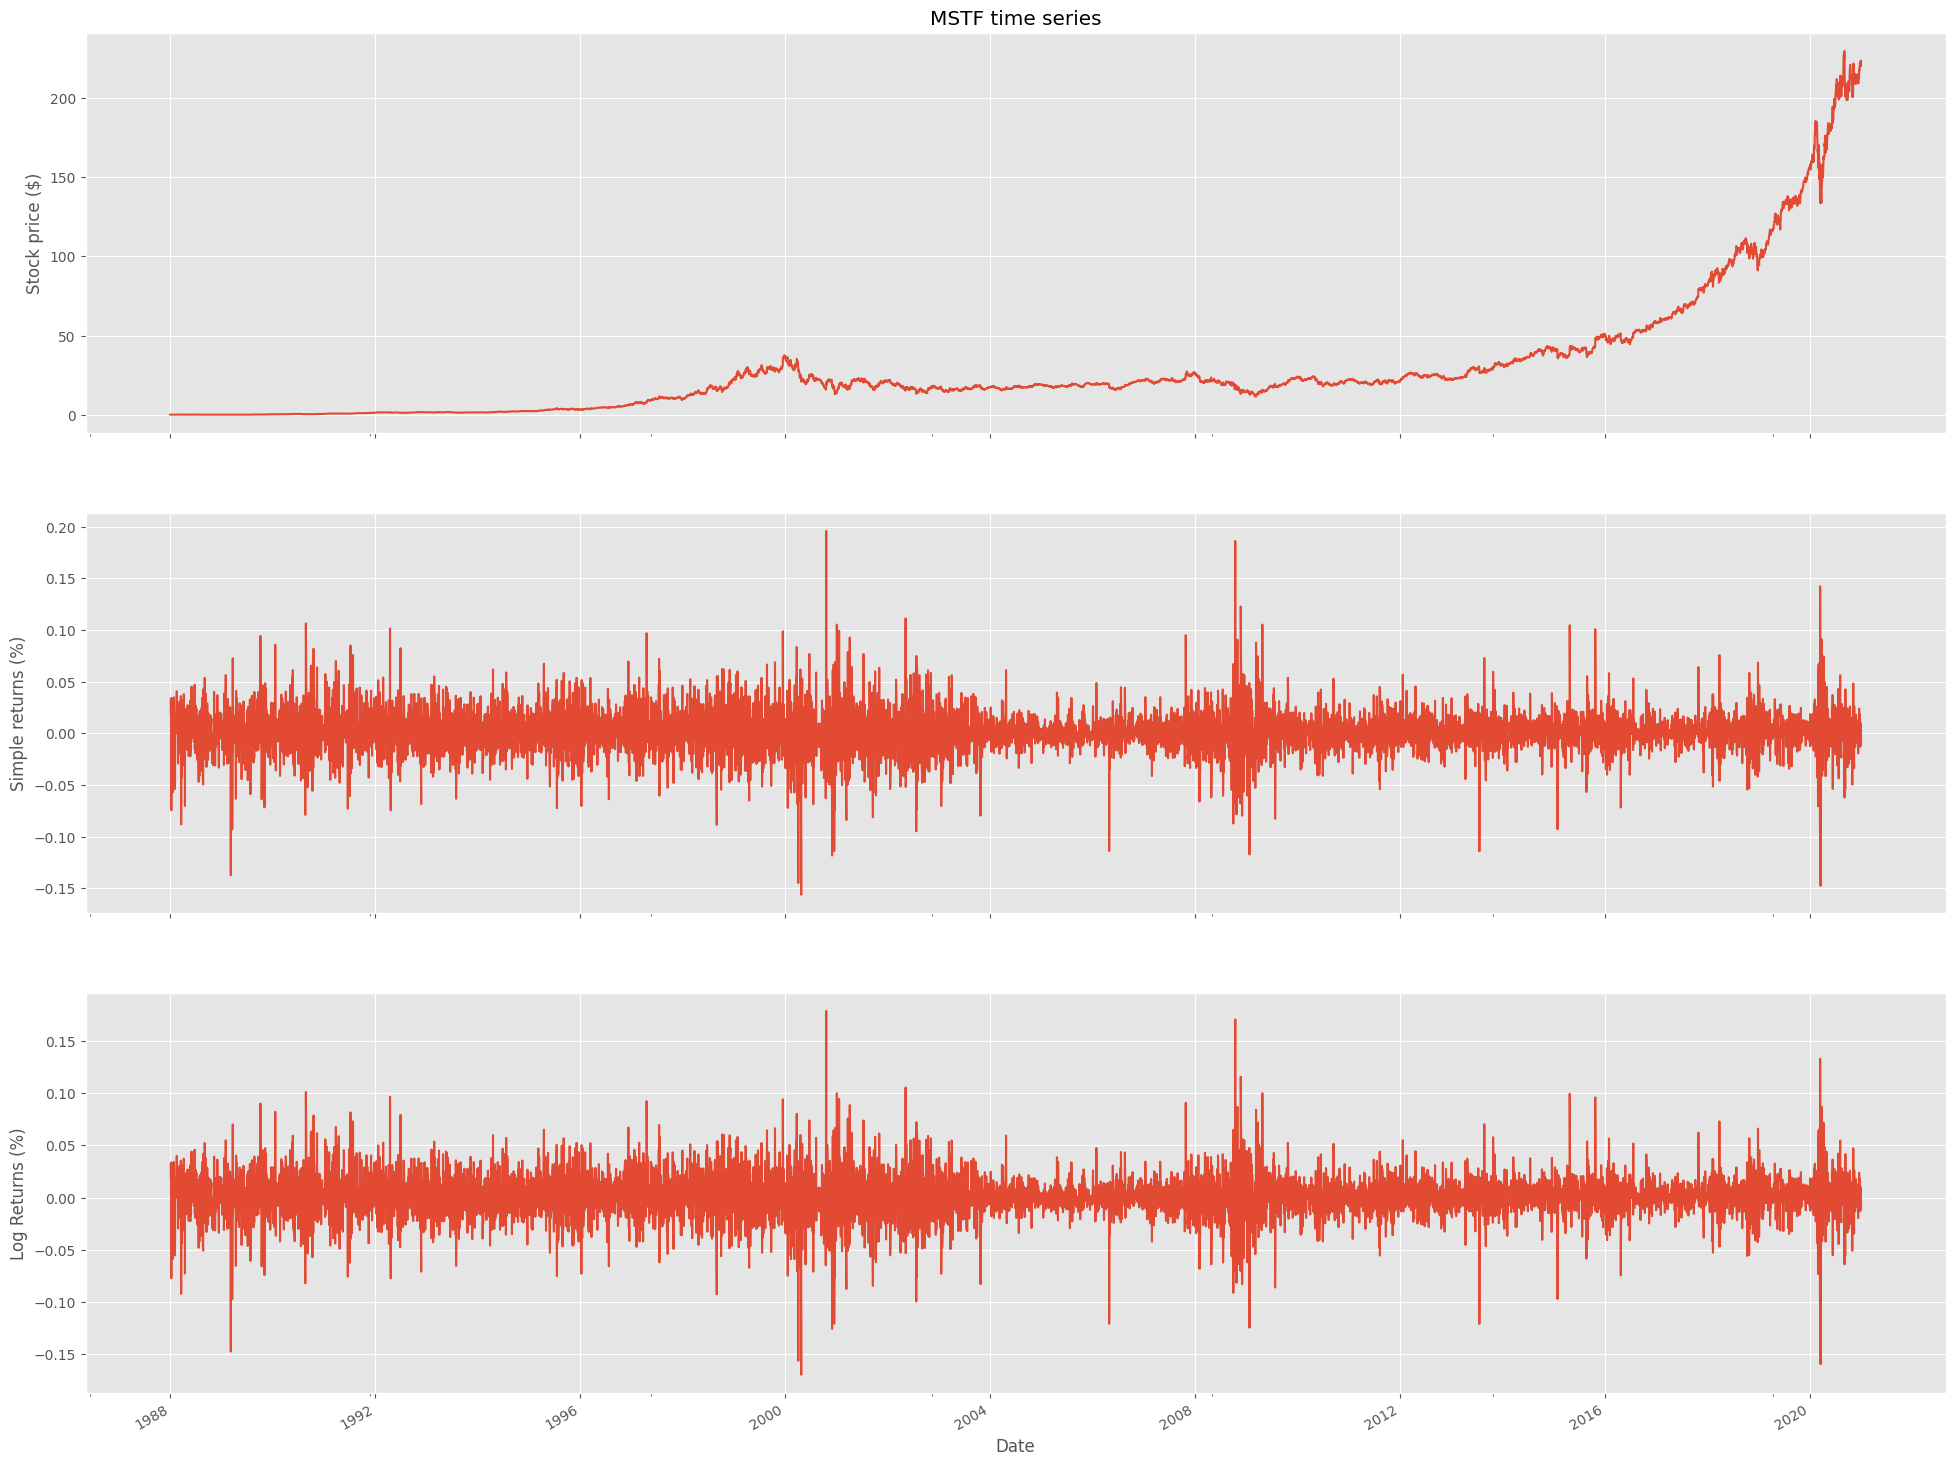

In [37]:
# Plotagem
fig, ax = plt.subplots(3,1, figsize=(24,20), sharex=True)

df.adj_close.plot(ax=ax[0])
ax[0].set(
    title='MSTF time series',
    ylabel='Stock price ($)'
)

df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Simple returns (%)')

df.log_rtn.plot(ax=ax[2])
ax[2].set(
    xlabel='Date',
    ylabel='Log Returns (%)'
)
plt.show()

## Identificando Outliers

In [38]:
# Blibliotecas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [39]:
# Options
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

In [40]:
# Download dos dados
df = yf.download(
    'AAPL',
    start='1999-12-31',
    end='2010-12-31',
    progress=False
)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

In [41]:
# Cálculo do retorno simples e do retorno logarítmico
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [42]:
# Cálculo da média móvel e do desvio padrão

df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [43]:
# Juntando as métricas aos dados originais
df_outliers = df.join(df_rolling)

In [44]:
# Função para a detecção de outliers
def identify_outiliers(row, n_sigmas=3):
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
        return 1
    else:
        return 0

In [45]:
# Identificação dos outliers
df_outliers['outlier'] = df_outliers.apply(identify_outiliers, axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, ['simple_rtn']]

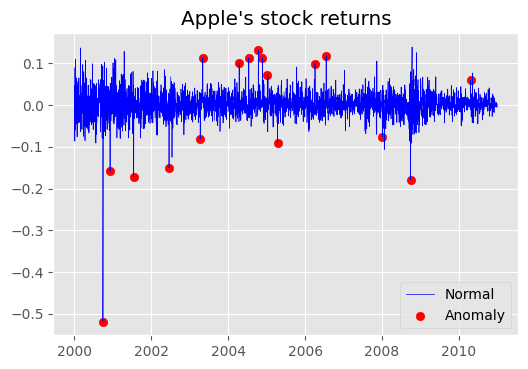

In [46]:
# Plotagem dos resultados
fig, ax = plt.subplots()

ax.plot(df_outliers.index, df_outliers.simple_rtn, color='blue', linewidth=0.5, label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')
plt.show()

## Investigando fatos estilizados de retornos de ativos

No que segue, vamos baixar os preços de ações da S&P 500 a partir do Yahoo Finance e calcular os retornos dos ativos.

In [47]:
# Bibliotecas importadas
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.descriptivestats import describe as smd

In [48]:
# Options
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn')

Vamos investigar, um por um, cinco fatos estilizados da série S&P 500.

In [49]:
# Download dos dados
df = yf.download('^GSPC',
                  start='1984-12-31',
                  end='2018-12-31',
                  progress=False)

df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
df.head()

,adj_close
Date,
1984-12-31,167.240005
1985-01-02,165.369995
1985-01-03,164.570007
1985-01-04,163.679993
1985-01-07,164.240005


In [50]:
# Cálculo dos retornos simples e logarítmico
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[1:]
df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
1985-01-02,165.369995,-0.011182,-0.011245
1985-01-03,164.570007,-0.004838,-0.004849
1985-01-04,163.679993,-0.005408,-0.005423
1985-01-07,164.240005,0.003421,0.003416
1985-01-08,163.990005,-0.001522,-0.001523


### Distribuição não gaussiana de retornos

1. Cálculo da __Função de Densidade de Probabilidade__ (_Probability Density Function_ - PDF) normal por meio da média e do desvio padrão dos retornos observados:

In [51]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2. Plotagem do histograma e gráfico Q-Q

/home/igoandrade/anaconda3/envs/ds39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


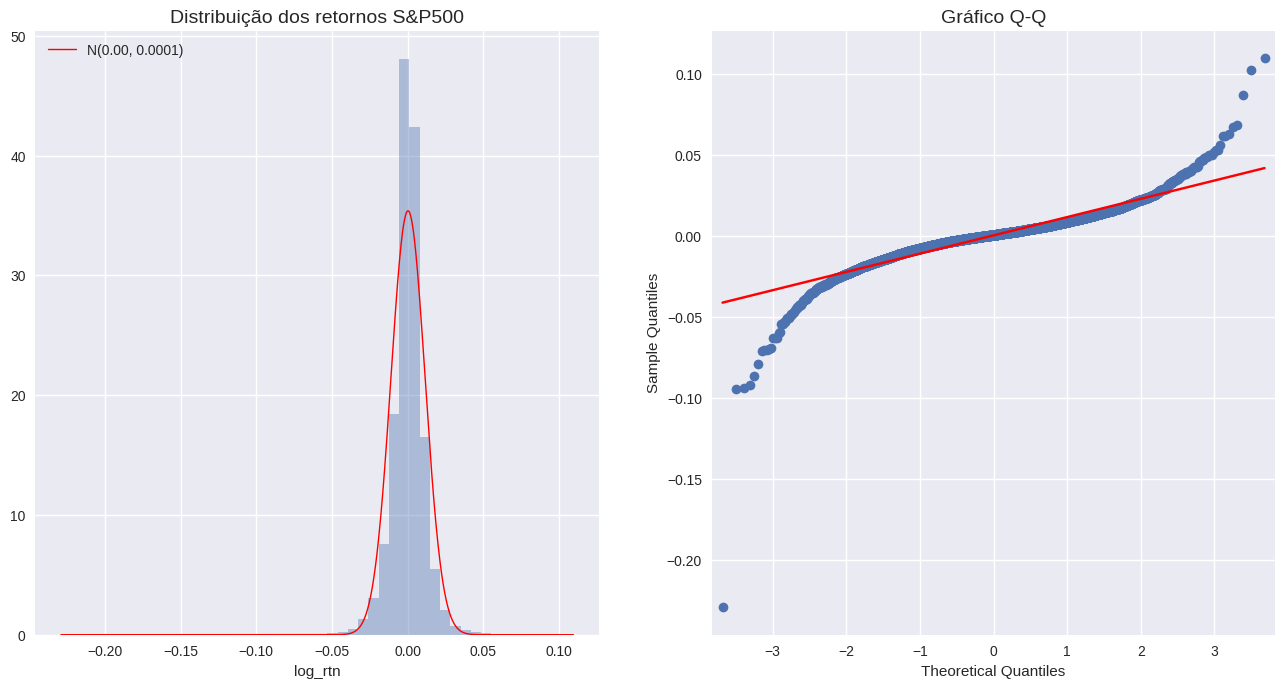

In [52]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

# Histograma
sns.distplot(df.log_rtn[1:], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribuição dos retornos S&P500', fontsize=14)
ax[0].plot(r_range, norm_pdf, 'r', lw=1, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values[1:], line='s', ax=ax[1])
ax[1].set_title('Gráfico Q-Q', fontsize=14)
plt.show()

In [53]:
desc_stats = smd(df.log_rtn)

In [54]:
desc_stats

,log_rtn
nobs,8569.000000
missing,0.000000
mean,0.000315
std_err,0.000001
upper_ci,0.000318
lower_ci,0.000312
std,0.011273
iqr,0.009867
iqr_normal,0.007315
mad,0.007407


### Clustering de volatilidade

1. Visualizção da série de retornos

<AxesSubplot:title={'center':'Retornos diários SP500'}, xlabel='Date'>

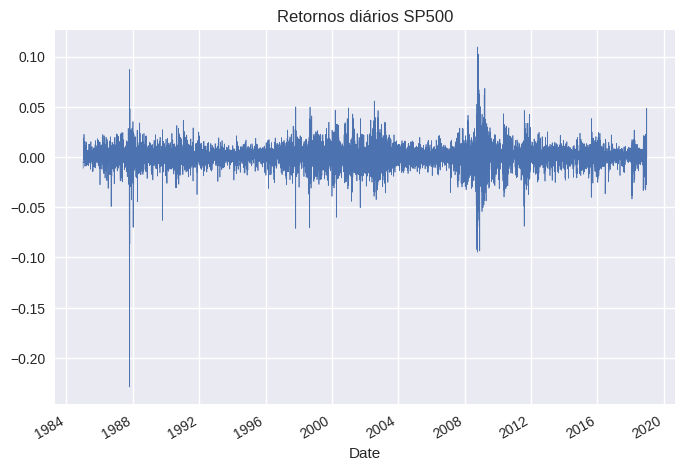

In [55]:
df.log_rtn.plot(title='Retornos diários SP500', linewidth=.5)

Existem clusters de volatividade - períodos de mais alto retorno positivo ou retorno negativo.

### Ausência de autocorrelação nos retornos

1. Definição dos parâmtros para a ccriação dos gráficos de autocorrelação

In [56]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2. Função de autocorrelação (Autocorrelation Function - ACF) para plotar os retornos logarítmicos

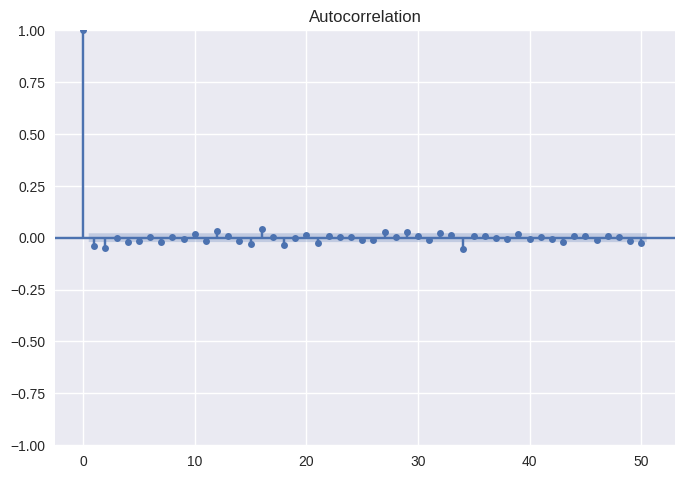

In [57]:
acf = smt.graphics.plot_acf(df.log_rtn,
                            lags=N_LAGS,
                            alpha=SIGNIFICANCE_LEVEL)

Apenas alguns valores estão fora do intervalo de confiança (não observamos o atraso 0) e podem ser considerados estatisticamente significativos. Podemos supor que verificamos que não há autocorrelação nas séries de retornos de log.

### Pequena e decrescente autocorrelação em retornos quadrados / absolutos

1. Criar o grágico ACF

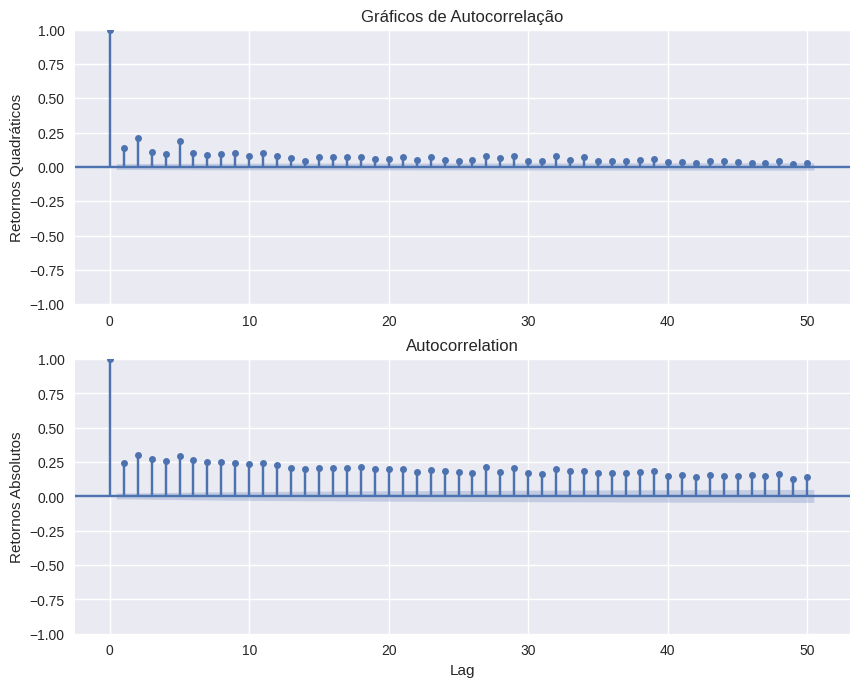

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title='Gráficos de Autocorrelação', ylabel='Retornos Quadráticos')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel='Retornos Absolutos', xlabel='Lag')

plt.show()

Observamos pequenos e decrescentes valores de autocorrelação dos retornos quadrático e absoluto, o que está em concordância com o fato estilizado anterior.

### Efeitos de alavancagem

1. Calcule as medidas de volatilidade como desvios-padrão móveis:

In [64]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

2. Plotagem de todas as séries para comparação

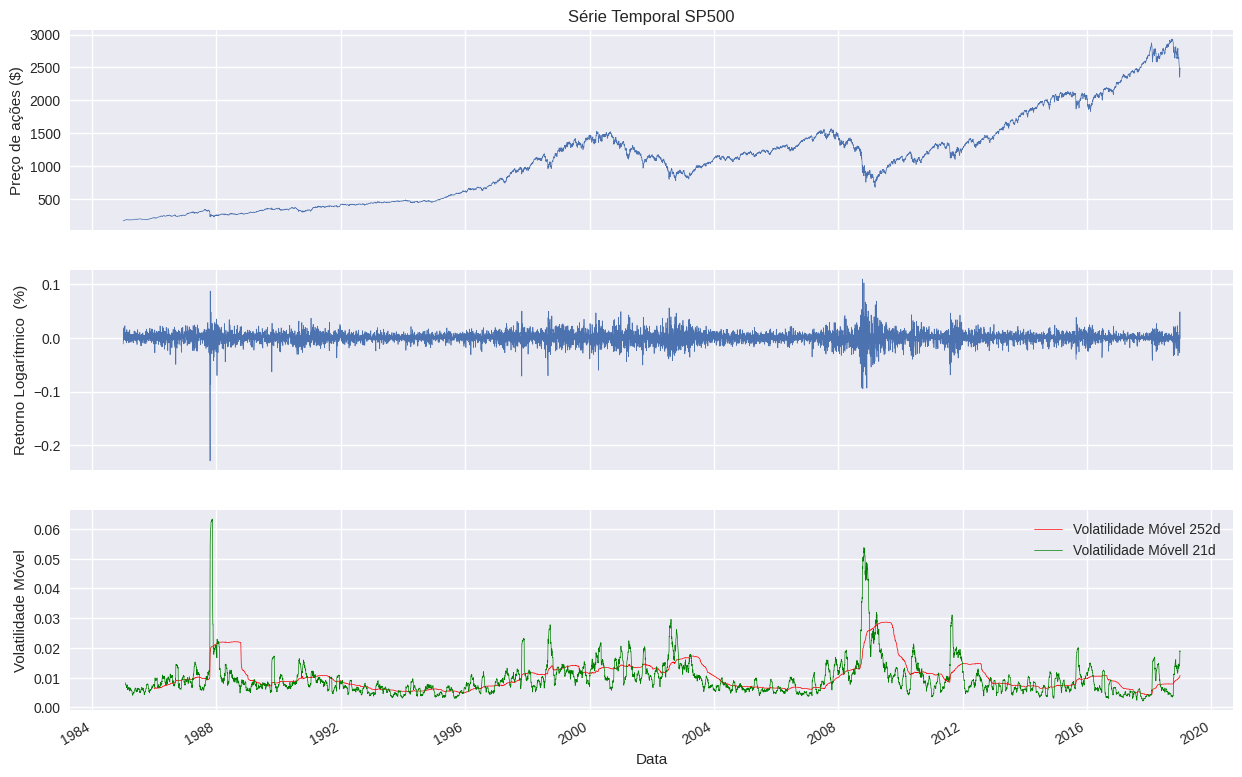

In [72]:
fig, ax = plt.subplots(3,1, figsize=(15,10), sharex=True)

df.adj_close.plot(ax=ax[0], linewidth=0.5)
ax[0].set(title='Série Temporal SP500', ylabel='Preço de ações ($)')

df.log_rtn.plot(ax=ax[1], linewidth=0.5)
ax[1].set(ylabel='Retorno Logarítmico  (%)')

df.moving_std_252.plot(ax=ax[2], color='r', linewidth=0.5, label='Volatilidade Móvel 252d')
df.moving_std_21.plot(ax=ax[2], color='g', linewidth=0.5, label='Volatilidade Móvell 21d')
ax[2].set(ylabel='Volatilidade Móvel', xlabel='Data')
ax[2].legend()

plt.show()

#### Método alternativo para investigar o efeito de alavancagem

Utiliza-se o índice VIX (CBOE Volatility Index) que é uma métrica popular da expectativa do mercado de ações
em relação à volatilidade.

1. Download e preprocessamento dos preços da S&P500 e VIX:

In [75]:
df = yf.download(['^GSPC', '^VIX'],
                 start='1985-01-01',
                 end='2018-12-31',
                 progress=False)

df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC':'sp500', '^VIX':'vix'})
df.tail()

,sp500,vix
Date,,
2018-12-21,2416.620117,30.110001
2018-12-24,2351.100098,36.070000
2018-12-26,2467.699951,30.410000
2018-12-27,2488.830078,29.959999
2018-12-28,2485.739990,28.340000


2. Cálculo do retorno logarítmico

In [77]:
df['log_rtn'] = np.log(df.sp500/df.sp500.shift(1))
df['vol_rtn'] = np.log(df.vix/df.vix.shift(1))
df.dropna(how='any', axis=0, inplace=True)
df.head()

,sp500,vix,log_rtn,vol_rtn
Date,,,,
1990-01-03,358.760010,18.190001,-0.002589,0.053640
1990-01-04,355.670013,19.219999,-0.008650,0.055079
1990-01-05,352.200012,20.110001,-0.009804,0.045266
1990-01-08,353.790009,20.260000,0.004504,0.007431
1990-01-09,349.619995,22.200001,-0.011857,0.091444


3. Gráfico de dispersão com os retornos sobre os eixos e uma curva de regressão linear para identificar a tendência:

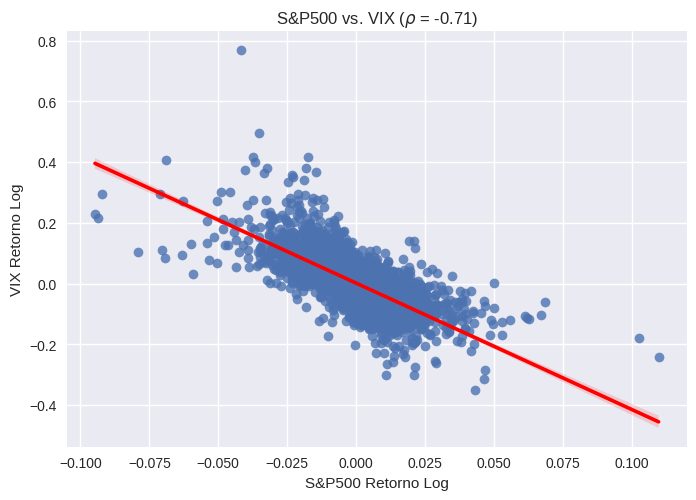

In [79]:
corr_coef = df.log_rtn.corr(df.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df, line_kws={'color':'red'})
ax.set(title=f'S&P500 vs. VIX ($\\rho$ = {corr_coef:.2f})',
       ylabel='VIX Retorno Log',
       xlabel='S&P500 Retorno Log')
plt.show()

A correlação negativa confirma a existência do efeito de alavancagem na série de retornos.